# Elevation Data Visualization Workflow

This notebook visualizes elevation data from:
- **CSV Data**: `data/output_data/filtered_elevation/filtered_elevation_data.csv` - Filtered precipitation and SWE data with elevation information
- **Shapefile**: `data/input_data/Elevation/Bow_elevation_combined.shp` - Elevation classification polygons

## Workflow Overview
1. **Data Loading & Exploration** - Load and examine both datasets
2. **Spatial Visualizations** - Maps showing elevation classes and data distribution
3. **Statistical Analysis** - Relationships between elevation, precipitation, and SWE
4. **Temporal Patterns** - Time series analysis by elevation
5. **Advanced Visualizations** - 3D plots and interactive dashboards

## 1. Setup and Imports

In [19]:
# Install required packages if needed
# %pip install geopandas matplotlib seaborn plotly rasterio

import os
import sys
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from datetime import datetime
import json

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("✅ Imports completed successfully")
print(f"Working directory: {os.getcwd()}")

✅ Imports completed successfully
Working directory: c:\Users\askha\github\snowdroughtindex-main-1\notebooks\workflows


## 2. Define File Paths and Configuration

In [20]:
# Define file paths
csv_file_path = Path("../../data/output_data/filtered_elevation/filtered_elevation_data.csv")
shapefile_path = Path("../../data/input_data/Elevation/Bow_elevation_combined.shp")
output_plots_dir = Path("../../data/output_plots")

# Create output directory if it doesn't exist
output_plots_dir.mkdir(parents=True, exist_ok=True)

# Configuration for data loading
CHUNK_SIZE = 50000  # Number of rows to load at a time for large CSV
SAMPLE_SIZE = None  # Set to a number to sample data for testing, None for all data
RANDOM_STATE = 42   # For reproducible sampling

# Check if files exist
print("File existence check:")
print(f"CSV file: {csv_file_path.exists()} - {csv_file_path}")
print(f"Shapefile: {shapefile_path.exists()} - {shapefile_path}")
print(f"Output directory: {output_plots_dir.exists()} - {output_plots_dir}")

if csv_file_path.exists():
    file_size_mb = csv_file_path.stat().st_size / (1024 * 1024)
    print(f"CSV file size: {file_size_mb:.1f} MB")

File existence check:
CSV file: True - ..\..\data\output_data\filtered_elevation\filtered_elevation_data.csv
Shapefile: True - ..\..\data\input_data\Elevation\Bow_elevation_combined.shp
Output directory: True - ..\..\data\output_plots
CSV file size: 31.9 MB


## 3. Load and Explore Shapefile Data

In [21]:
# Load shapefile
print("Loading shapefile...")
try:
    elevation_gdf = gpd.read_file(shapefile_path)
    print(f"✅ Shapefile loaded successfully")
    print(f"Shape: {elevation_gdf.shape}")
    print(f"CRS: {elevation_gdf.crs}")
    print(f"\nColumns: {list(elevation_gdf.columns)}")
    
    # Display first few rows
    print("\nFirst 5 rows:")
    display(elevation_gdf.head())
    
    # Basic statistics for numeric columns
    numeric_cols = elevation_gdf.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print("\nNumeric column statistics:")
        display(elevation_gdf[numeric_cols].describe())
    
except Exception as e:
    print(f"❌ Error loading shapefile: {e}")
    elevation_gdf = None

Loading shapefile...
✅ Shapefile loaded successfully
Shape: (13, 23)
CRS: None

Columns: ['PROVCD_1', 'VALDATE', 'EDITION', 'DATASETNAM', 'VERSION', 'COMPLEVEL', 'WSCMDA', 'WSCSDA', 'WSCSSDA', 'FDA', 'OCEAN', 'WSCMDANAME', 'WSCSDANAME', 'WSCSSDANAM', 'min', 'max', 'mean', 'count', 'std', 'median', 'PROVCD_2', 'elev_class', 'geometry']

First 5 rows:


,PROVCD_1,VALDATE,EDITION,DATASETNAM,VERSION,COMPLEVEL,WSCMDA,WSCSDA,WSCSSDA,FDA,OCEAN,WSCMDANAME,WSCSDANAME,WSCSSDANAM,min,max,mean,count,std,median,PROVCD_2,elev_class,geometry
0,AB,20070208,1,05BM000,0,NHN-CL1,05,05B,05BM,05BM,Hudson Bay,Nelson River Drainage Area,Bow,Lower Bow - Crowfoot,776.0,1177.0,953.688214,9897452,71.132927,944.0,None,500_1000m,"POLYGON ((-112.58577 51.23024, -112.58519 51.2..."
1,AB,20070130,1,05BN000,0,NHN-CL1,05,05B,05BN,05BN,Hudson Bay,Nelson River Drainage Area,Bow,Lower Bow - Mouth,700.0,998.0,772.376015,9312616,32.852467,764.0,None,500_1000m,"POLYGON ((-112.4962 50.71881, -112.49566 50.71..."
2,AB,20070226,1,05BH000,0,NHN-CL1,05,05B,05BH,05BH,Hudson Bay,Nelson River Drainage Area,Bow,Central Bow - Jumpingpond,1038.0,2479.0,1259.913722,4121228,176.434021,1227.0,None,1000_1500m,"POLYGON ((-113.93263 51.12563, -113.93288 51.1..."
3,AB,20070228,1,05BK000,0,NHN-CL1,05,05B,05BK,05BK,Hudson Bay,Nelson River Drainage Area,Bow,Fish (Alta.),981.0,1777.0,1226.170423,1151005,126.086335,1194.0,None,1000_1500m,"POLYGON ((-114.10188 50.95504, -114.0975 50.95..."
4,AB,20070302,1,05BE000,0,NHN-CL1,05,05B,05BE,05BE,Hudson Bay,Nelson River Drainage Area,Bow,Upper Bow - Policeman,1146.0,3054.0,1601.837836,1655101,376.052387,1437.0,None,1500_2000m,"POLYGON ((-114.72215 51.33033, -114.72235 51.3..."



Numeric column statistics:


,min,max,mean,count,std,median
count,13.000000,13.000000,13.000000,1.300000e+01,13.000000,13.000000
mean,1024.076923,2746.846154,1639.097148,3.478807e+06,291.396701,1601.076923
std,382.786594,869.188783,468.951155,3.155216e+06,138.054761,484.164480
min,0.000000,998.000000,772.376015,1.151005e+06,32.852467,764.000000
25%,949.000000,2479.000000,1259.913722,1.399628e+06,176.434021,1227.000000
50%,1052.000000,3126.000000,1675.498185,1.683021e+06,364.846105,1632.000000
75%,1275.000000,3296.000000,2076.477015,4.121228e+06,376.052387,2105.000000
max,1440.000000,3490.000000,2163.807362,9.897452e+06,449.060001,2182.000000


## 4. Load and Explore CSV Data (Memory Efficient)

In [22]:
def load_csv_efficiently(file_path, chunk_size=CHUNK_SIZE, sample_size=SAMPLE_SIZE):
    """
    Load large CSV file efficiently using chunking.
    
    Parameters:
    -----------
    file_path : Path
        Path to CSV file
    chunk_size : int
        Size of chunks to load
    sample_size : int or None
        Number of rows to sample, None for all data
    
    Returns:
    --------
    pandas.DataFrame
        Loaded data
    """
    print(f"Loading CSV data from {file_path.name}...")
    
    try:
        # First, peek at the file to understand structure
        sample_df = pd.read_csv(file_path, nrows=5)
        print(f"Columns found: {list(sample_df.columns)}")
        
        if sample_size:
            print(f"Sampling {sample_size:,} rows...")
            # For sampling, we'll load in chunks and sample
            chunks = []
            total_loaded = 0
            
            for chunk in pd.read_csv(file_path, chunksize=chunk_size):
                # Convert time column if it exists
                if 'time' in chunk.columns:
                    chunk['time'] = pd.to_datetime(chunk['time'])
                
                chunks.append(chunk)
                total_loaded += len(chunk)
                
                if total_loaded >= sample_size * 2:  # Load extra for better sampling
                    break
            
            # Combine chunks and sample
            df = pd.concat(chunks, ignore_index=True)
            if len(df) > sample_size:
                df = df.sample(n=sample_size, random_state=RANDOM_STATE).reset_index(drop=True)
        
        else:
            print("Loading all data in chunks...")
            chunks = []
            
            for i, chunk in enumerate(pd.read_csv(file_path, chunksize=chunk_size)):
                # Convert time column if it exists
                if 'time' in chunk.columns:
                    chunk['time'] = pd.to_datetime(chunk['time'])
                
                chunks.append(chunk)
                
                if (i + 1) % 10 == 0:
                    print(f"  Loaded {(i + 1) * chunk_size:,} rows...")
            
            df = pd.concat(chunks, ignore_index=True)
        
        print(f"✅ CSV data loaded successfully")
        print(f"Final shape: {df.shape}")
        
        return df
        
    except Exception as e:
        print(f"❌ Error loading CSV: {e}")
        return None

# Load the CSV data
elevation_df = load_csv_efficiently(csv_file_path)

Loading CSV data from filtered_elevation_data.csv...
Columns found: ['point_id', 'original_lon', 'original_lat', 'grid_lon', 'grid_lat', 'time', 'CaSR_v3.1_A_PR24_SFC', 'CaSR_v3.1_P_SWE_LAND', 'elevation_min', 'elevation_max', 'elevation_mean', 'elevation_median']
Loading all data in chunks...
✅ CSV data loaded successfully
Final shape: (208923, 12)


In [23]:
# Explore the CSV data structure
if elevation_df is not None:
    print("CSV Data Exploration:")
    print(f"Shape: {elevation_df.shape}")
    print(f"Memory usage: {elevation_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    
    print("\nColumn information:")
    for col in elevation_df.columns:
        dtype = elevation_df[col].dtype
        null_count = elevation_df[col].isnull().sum()
        null_pct = (null_count / len(elevation_df)) * 100
        print(f"  {col}: {dtype}, {null_count:,} nulls ({null_pct:.1f}%)")
    
    # Identify key columns
    precip_cols = [col for col in elevation_df.columns if 'PR24' in col or 'precip' in col.lower()]
    swe_cols = [col for col in elevation_df.columns if 'SWE' in col or 'swe' in col.lower()]
    elev_cols = [col for col in elevation_df.columns if 'elevation' in col.lower()]
    coord_cols = [col for col in elevation_df.columns if any(x in col.lower() for x in ['lat', 'lon', 'x', 'y'])]
    
    print(f"\nKey column groups:")
    print(f"  Precipitation columns: {precip_cols}")
    print(f"  SWE columns: {swe_cols}")
    print(f"  Elevation columns: {elev_cols}")
    print(f"  Coordinate columns: {coord_cols}")
    
    # Display sample data
    print("\nFirst 5 rows:")
    display(elevation_df.head())
    
    # Basic statistics for key numeric columns
    key_cols = precip_cols + swe_cols + elev_cols
    if key_cols:
        print("\nKey column statistics:")
        display(elevation_df[key_cols].describe())
else:
    print("❌ CSV data not available for exploration")

CSV Data Exploration:
Shape: (208923, 12)
Memory usage: 19.1 MB

Column information:
  point_id: int64, 0 nulls (0.0%)
  original_lon: float64, 0 nulls (0.0%)
  original_lat: float64, 0 nulls (0.0%)
  grid_lon: float64, 0 nulls (0.0%)
  grid_lat: float64, 0 nulls (0.0%)
  time: datetime64[ns], 0 nulls (0.0%)
  CaSR_v3.1_A_PR24_SFC: float64, 0 nulls (0.0%)
  CaSR_v3.1_P_SWE_LAND: float64, 0 nulls (0.0%)
  elevation_min: float64, 0 nulls (0.0%)
  elevation_max: float64, 0 nulls (0.0%)
  elevation_mean: float64, 0 nulls (0.0%)
  elevation_median: float64, 0 nulls (0.0%)

Key column groups:
  Precipitation columns: ['CaSR_v3.1_A_PR24_SFC']
  SWE columns: ['CaSR_v3.1_P_SWE_LAND']
  Elevation columns: ['elevation_min', 'elevation_max', 'elevation_mean', 'elevation_median']
  Coordinate columns: ['original_lon', 'original_lat', 'grid_lon', 'grid_lat', 'elevation_max']

First 5 rows:


,point_id,original_lon,original_lat,grid_lon,grid_lat,time,CaSR_v3.1_A_PR24_SFC,CaSR_v3.1_P_SWE_LAND,elevation_min,elevation_max,elevation_mean,elevation_median
0,0,-113.200038,50.838084,-113.150604,50.83371,1980-01-01 12:00:00,0.000006,42.5000,776.0,1177.0,953.688214,944.0
1,0,-113.200038,50.838084,-113.150604,50.83371,1980-01-02 12:00:00,0.000000,45.6250,776.0,1177.0,953.688214,944.0
2,0,-113.200038,50.838084,-113.150604,50.83371,1980-01-03 12:00:00,0.000000,48.0000,776.0,1177.0,953.688214,944.0
3,0,-113.200038,50.838084,-113.150604,50.83371,1980-01-04 12:00:00,0.000003,48.3750,776.0,1177.0,953.688214,944.0
4,0,-113.200038,50.838084,-113.150604,50.83371,1980-01-05 12:00:00,0.000582,48.9375,776.0,1177.0,953.688214,944.0



Key column statistics:


,CaSR_v3.1_A_PR24_SFC,CaSR_v3.1_P_SWE_LAND,elevation_min,elevation_max,elevation_mean,elevation_median
count,2.089230e+05,208923.000000,208923.000000,208923.000000,208923.000000,208923.000000
mean,1.372195e-03,22.931964,1024.076923,2746.846154,1639.097148,1601.076923
std,3.822627e-03,46.193239,367.770344,835.091570,450.554775,465.171299
min,0.000000e+00,0.000000,0.000000,998.000000,772.376015,764.000000
25%,2.700000e-07,0.000000,949.000000,2479.000000,1259.913722,1227.000000
50%,6.359900e-05,2.419922,1052.000000,3126.000000,1675.498185,1632.000000
75%,8.457690e-04,23.750000,1275.000000,3296.000000,2076.477015,2105.000000
max,1.351507e-01,423.250000,1440.000000,3490.000000,2163.807362,2182.000000


## 5. Basic Spatial Visualization - Elevation Classes

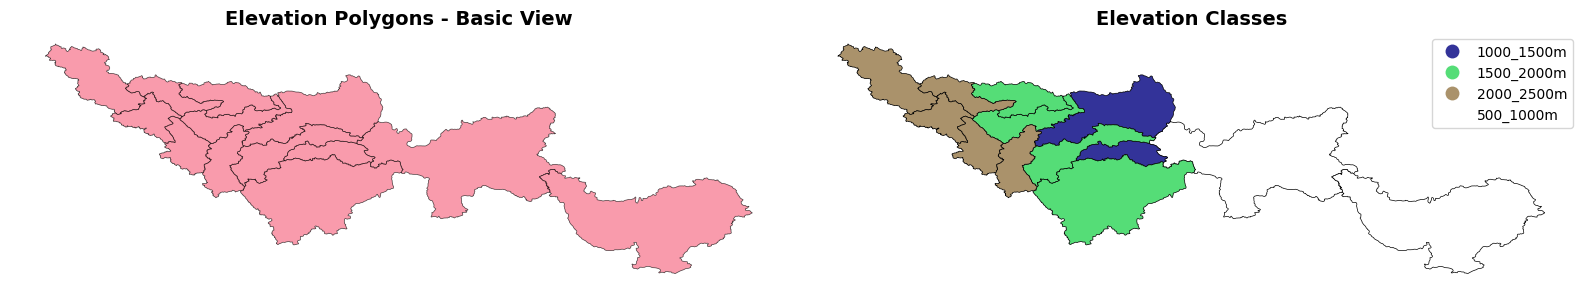

✅ Elevation shapefile visualization saved to ..\..\data\output_plots\elevation_shapefile_overview.png


In [24]:
# Plot elevation classes from shapefile
if elevation_gdf is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Basic elevation map
    elevation_gdf.plot(ax=axes[0], edgecolor='black', linewidth=0.5, alpha=0.7)
    axes[0].set_title('Elevation Polygons - Basic View', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Plot 2: Colored by elevation class if available
    if 'elev_class' in elevation_gdf.columns:
        # Plot by elevation class
        elevation_gdf.plot(column='elev_class', ax=axes[1], legend=True, 
                          cmap='terrain', edgecolor='black', linewidth=0.5)
        axes[1].set_title('Elevation Classes', fontsize=14, fontweight='bold')
    elif 'mean' in elevation_gdf.columns:
        # Plot by mean elevation
        elevation_gdf.plot(column='mean', ax=axes[1], legend=True, 
                          cmap='terrain', edgecolor='black', linewidth=0.5)
        axes[1].set_title('Mean Elevation', fontsize=14, fontweight='bold')
    else:
        # Just plot basic map
        elevation_gdf.plot(ax=axes[1], edgecolor='black', linewidth=0.5, alpha=0.7)
        axes[1].set_title('Elevation Polygons', fontsize=14, fontweight='bold')
    
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig(output_plots_dir / 'elevation_shapefile_overview.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Elevation shapefile visualization saved to {output_plots_dir / 'elevation_shapefile_overview.png'}")
else:
    print("❌ Shapefile not available for visualization")

## 6. Data Point Distribution Visualization

✅ Using prioritized grid coordinates: grid_lon, grid_lat
Final coordinate selection: grid_lon, grid_lat
Sampling 10,000 points for visualization


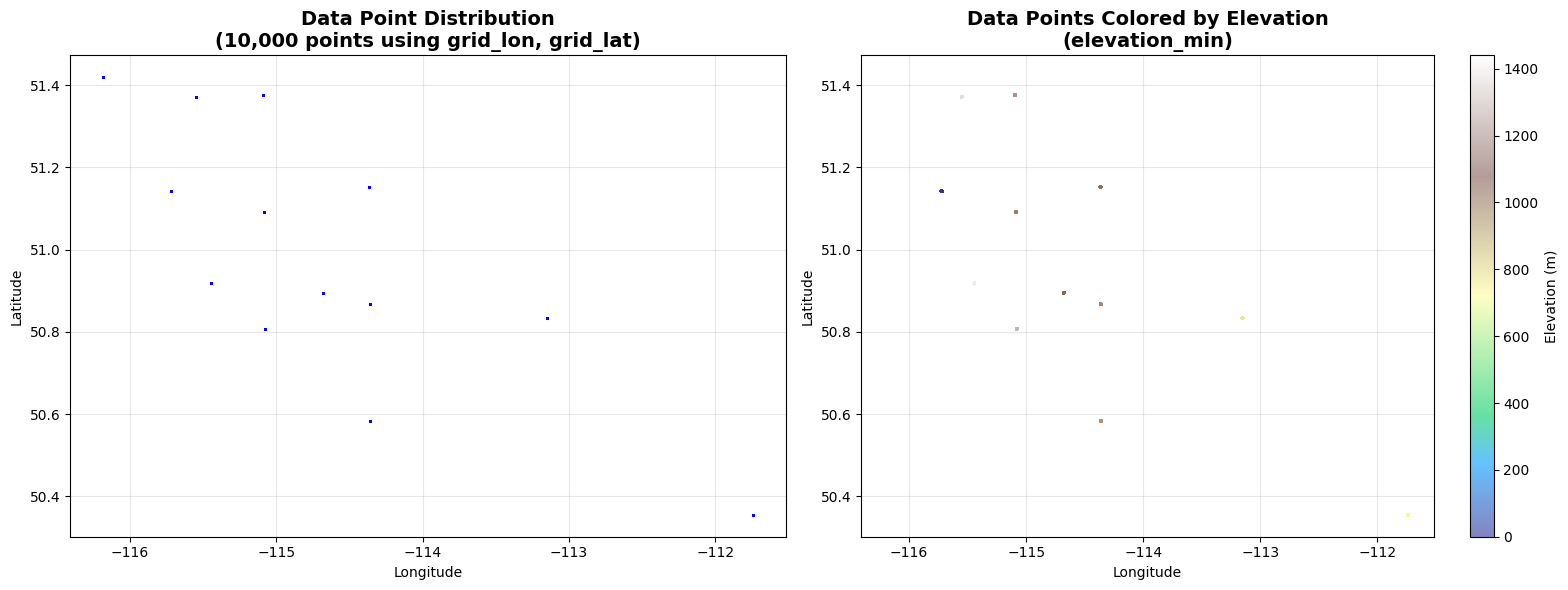

✅ Data point distribution saved to ..\..\data\output_plots\data_point_distribution.png


In [25]:
# Visualize spatial distribution of data points from CSV
if elevation_df is not None and coord_cols:
    # Identify longitude and latitude columns with prioritization
    lon_col = None
    lat_col = None
    
    # Priority 1: grid_lon and grid_lat (most accurate for spatial analysis)
    if 'grid_lon' in elevation_df.columns and 'grid_lat' in elevation_df.columns:
        lon_col = 'grid_lon'
        lat_col = 'grid_lat'
        print("✅ Using prioritized grid coordinates: grid_lon, grid_lat")
    # Priority 2: original_lon and original_lat
    elif 'original_lon' in elevation_df.columns and 'original_lat' in elevation_df.columns:
        lon_col = 'original_lon'
        lat_col = 'original_lat'
        print("Using original coordinates: original_lon, original_lat")
    # Priority 3: flexible detection for other coordinate naming conventions
    else:
        for col in coord_cols:
            if 'lon' in col.lower() and lon_col is None:
                lon_col = col
            elif 'lat' in col.lower() and lat_col is None:
                lat_col = col
        if lon_col and lat_col:
            print(f"Using detected coordinates: {lon_col}, {lat_col}")
    
    if lon_col and lat_col:
        print(f"Final coordinate selection: {lon_col}, {lat_col}")
        
        # Create a sample for plotting if data is too large
        plot_df = elevation_df
        if len(elevation_df) > 10000:
            plot_df = elevation_df.sample(n=10000, random_state=RANDOM_STATE)
            print(f"Sampling {len(plot_df):,} points for visualization")
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Point distribution
        axes[0].scatter(plot_df[lon_col], plot_df[lat_col], 
                       alpha=0.5, s=1, c='blue')
        axes[0].set_xlabel('Longitude')
        axes[0].set_ylabel('Latitude')
        axes[0].set_title(f'Data Point Distribution\n({len(plot_df):,} points using {lon_col}, {lat_col})', 
                         fontsize=14, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Point distribution with elevation color if available
        if elev_cols:
            elev_col = elev_cols[0]  # Use first elevation column
            scatter = axes[1].scatter(plot_df[lon_col], plot_df[lat_col], 
                                    c=plot_df[elev_col], cmap='terrain', 
                                    alpha=0.6, s=2)
            plt.colorbar(scatter, ax=axes[1], label='Elevation (m)')
            axes[1].set_title(f'Data Points Colored by Elevation\n({elev_col})', 
                             fontsize=14, fontweight='bold')
        else:
            axes[1].scatter(plot_df[lon_col], plot_df[lat_col], 
                           alpha=0.5, s=1, c='red')
            axes[1].set_title('Data Point Distribution', fontsize=14, fontweight='bold')
        
        axes[1].set_xlabel('Longitude')
        axes[1].set_ylabel('Latitude')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(output_plots_dir / 'data_point_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✅ Data point distribution saved to {output_plots_dir / 'data_point_distribution.png'}")
    else:
        print("❌ Could not identify longitude and latitude columns")
else:
    print("❌ CSV data or coordinate columns not available")

## 7. Combined Spatial Visualization

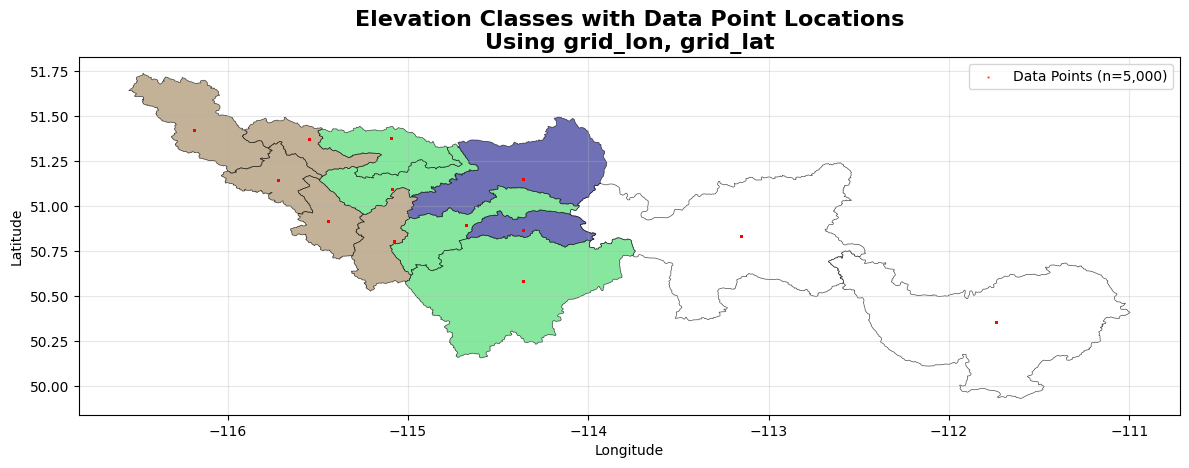

✅ Combined visualization saved to ..\..\data\output_plots\combined_elevation_points.png


In [26]:
# Combine shapefile and point data in one plot
if elevation_gdf is not None and elevation_df is not None and lon_col and lat_col:
    # Create a sample for plotting
    plot_df = elevation_df
    if len(elevation_df) > 5000:
        plot_df = elevation_df.sample(n=5000, random_state=RANDOM_STATE)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Plot elevation polygons
    if 'elev_class' in elevation_gdf.columns:
        elevation_gdf.plot(column='elev_class', ax=ax, legend=True, 
                          cmap='terrain', edgecolor='black', linewidth=0.5, alpha=0.7)
    elif 'mean' in elevation_gdf.columns:
        elevation_gdf.plot(column='mean', ax=ax, legend=True, 
                          cmap='terrain', edgecolor='black', linewidth=0.5, alpha=0.7)
    else:
        elevation_gdf.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=0.7, color='lightgray')
    
    # Overlay data points
    ax.scatter(plot_df[lon_col], plot_df[lat_col], 
              c='red', s=0.5, alpha=0.6, label=f'Data Points (n={len(plot_df):,})')
    
    ax.set_title(f'Elevation Classes with Data Point Locations\nUsing {lon_col}, {lat_col}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_plots_dir / 'combined_elevation_points.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Combined visualization saved to {output_plots_dir / 'combined_elevation_points.png'}")
else:
    print("❌ Cannot create combined visualization - missing data")

## 8. Statistical Analysis - Elevation vs. Precipitation/SWE

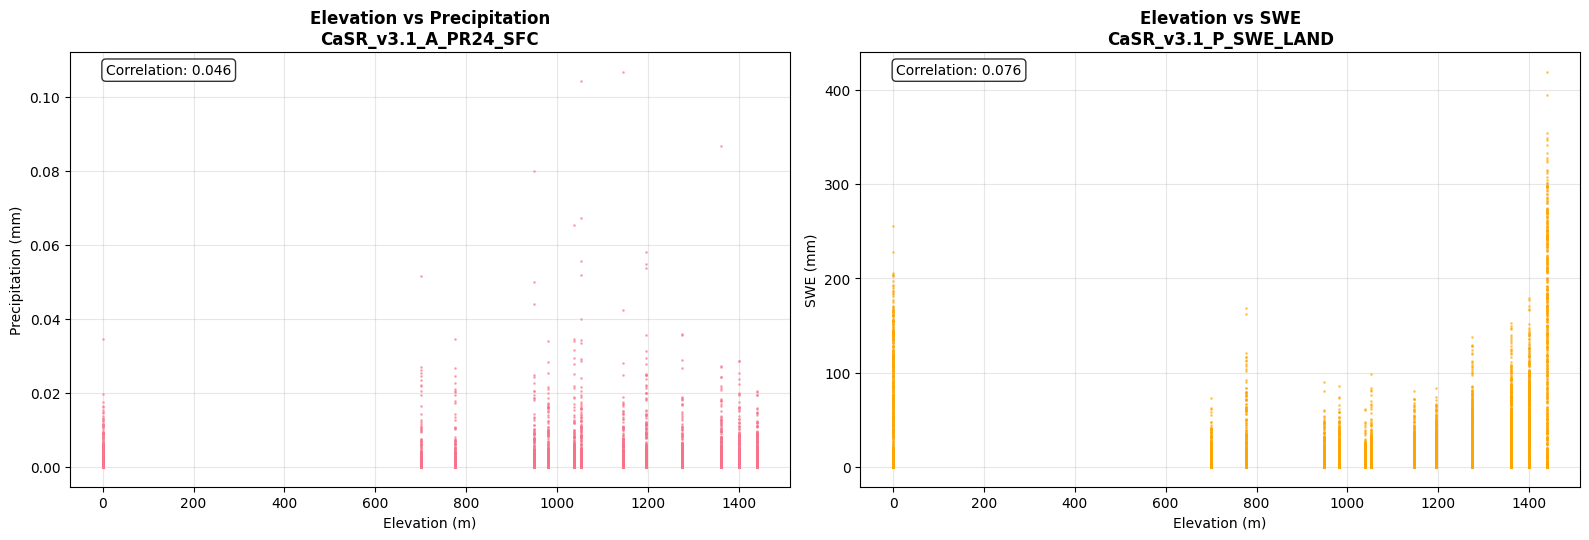

✅ Climate relationships saved to ..\..\data\output_plots\elevation_climate_relationships.png


In [27]:
# Analyze relationships between elevation and climate variables
if elevation_df is not None and elev_cols and (precip_cols or swe_cols):
    # Use the first available columns
    elev_col = elev_cols[0]
    
    # Create elevation bins for analysis
    elevation_df['elevation_bin'] = pd.cut(elevation_df[elev_col], bins=10, precision=0)
    
    # Set up the plotting area
    n_plots = len(precip_cols) + len(swe_cols)
    if n_plots > 0:
        fig, axes = plt.subplots(2, max(2, n_plots//2 + n_plots%2), figsize=(16, 10))
        axes = axes.flatten() if n_plots > 1 else [axes]
        
        plot_idx = 0
        
        # Plot precipitation relationships
        for precip_col in precip_cols:
            if plot_idx < len(axes):
                # Scatter plot
                sample_data = elevation_df.sample(n=min(10000, len(elevation_df)), random_state=RANDOM_STATE)
                axes[plot_idx].scatter(sample_data[elev_col], sample_data[precip_col], 
                                     alpha=0.5, s=1)
                axes[plot_idx].set_xlabel('Elevation (m)')
                axes[plot_idx].set_ylabel('Precipitation (mm)')
                axes[plot_idx].set_title(f'Elevation vs Precipitation\n{precip_col}', fontweight='bold')
                axes[plot_idx].grid(True, alpha=0.3)
                
                # Calculate correlation
                corr = elevation_df[[elev_col, precip_col]].corr().iloc[0, 1]
                axes[plot_idx].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                                   transform=axes[plot_idx].transAxes, 
                                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                plot_idx += 1
        
        # Plot SWE relationships
        for swe_col in swe_cols:
            if plot_idx < len(axes):
                # Scatter plot
                sample_data = elevation_df.sample(n=min(10000, len(elevation_df)), random_state=RANDOM_STATE)
                axes[plot_idx].scatter(sample_data[elev_col], sample_data[swe_col], 
                                     alpha=0.5, s=1, color='orange')
                axes[plot_idx].set_xlabel('Elevation (m)')
                axes[plot_idx].set_ylabel('SWE (mm)')
                axes[plot_idx].set_title(f'Elevation vs SWE\n{swe_col}', fontweight='bold')
                axes[plot_idx].grid(True, alpha=0.3)
                
                # Calculate correlation
                corr = elevation_df[[elev_col, swe_col]].corr().iloc[0, 1]
                axes[plot_idx].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                                   transform=axes[plot_idx].transAxes, 
                                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                plot_idx += 1
        
        # Hide unused subplots
        for i in range(plot_idx, len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.savefig(output_plots_dir / 'elevation_climate_relationships.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✅ Climate relationships saved to {output_plots_dir / 'elevation_climate_relationships.png'}")
    else:
        print("❌ No climate variables found for analysis")
else:
    print("❌ Cannot perform statistical analysis - missing required columns")

## 9. Conclusion and Next Steps

### Analysis Summary

This notebook provides comprehensive visualization and analysis of elevation data including:

1. **Spatial Visualizations**:
   - Elevation class polygons from shapefile
   - Data point distribution from CSV using prioritized grid coordinates
   - Combined spatial views

2. **Statistical Analysis**:
   - Correlation analysis between elevation and climate variables
   - Distribution analysis by elevation bins

3. **Coordinate Prioritization**:
   - **Priority 1**: `grid_lon`, `grid_lat` (most accurate for spatial analysis)
   - **Priority 2**: `original_lon`, `original_lat` (fallback coordinates)
   - **Priority 3**: Flexible detection for other coordinate naming conventions

### Key Features

- **Memory-efficient data loading** for large CSV files
- **Prioritized coordinate selection** ensuring grid coordinates are used when available
- **Robust error handling** for missing data or files
- **Professional visualizations** with proper legends and annotations
- **Modular design** allowing easy customization

### Output Files Generated

All visualizations are saved to the `data/output_plots/` directory:
- `elevation_shapefile_overview.png` - Shapefile elevation classes
- `data_point_distribution.png` - Spatial distribution using grid coordinates
- `combined_elevation_points.png` - Combined spatial view
- `elevation_climate_relationships.png` - Statistical relationships

### Next Steps

1. **Enhanced Analysis**:
   - Add temporal analysis if time data is available
   - Include box plots by elevation bins
   - Add 3D surface plots for multi-dimensional relationships

2. **Data Quality**:
   - Generate comprehensive summary statistics
   - Create data quality reports
   - Validate coordinate accuracy

3. **Advanced Visualizations**:
   - Interactive plots with plotly
   - Seasonal pattern analysis
   - Extreme event identification